In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [3]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [4]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
#early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
#insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
#lrv_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LeafRoll',224))
#virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
#early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
#insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
#lrv_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LeafRoll',224))
#virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 205/205 [00:03<00:00, 61.79it/s] 


In [5]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
#early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),1)
healthy_train_label = np.full(len(healthy_train),2)
#insect_train_label = np.full(len(insect_train),4)
#lrv_train_label = np.full(len(lrv_train),5)
#virus_train_label = np.full(len(virus_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
#early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),1)
healthy_test_label = np.full(len(healthy_test),2)
#insect_test_label = np.full(len(insect_test),4)
#lrv_test_label = np.full(len(lrv_test),5)
#virus_test_label = np.full(len(virus_test),6)

In [6]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, late_blight_train, healthy_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, late_blight_train_label, healthy_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, late_blight_test, healthy_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, late_blight_test_label, healthy_test_label), axis = 0)

In [7]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [8]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [10]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [11]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

Xception     = Xception(include_top=False, input_shape=input_shape)(inputs)

83683744/83683744 [==============================] - 1s 0us/step


In [12]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(Xception)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(3, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 concatenate (Concatenate)   (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                            

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/Xception(3_classes).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [14]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
60/60 [==============================] - ETA: 0s - loss: 0.7645 - accuracy: 0.6849

60/60 [==============================] - 60s 665ms/step - loss: 0.7645 - accuracy: 0.6849 - val_loss: 0.3673 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 2/20
60/60 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.8839

60/60 [==============================] - 39s 643ms/step - loss: 0.2869 - accuracy: 0.8839 - val_loss: 0.0782 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 3/20
60/60 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9219

60/60 [==============================] - 41s 672ms/step - loss: 0.2077 - accuracy: 0.9219 - val_loss: 0.0277 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/20
60/60 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9349

60/60 [==============================] - 40s 662ms/step - loss: 0.1669 - accuracy: 0.9349 - val_loss: 0.0234 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/20
60/60 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9385

60/60 [==============================] - 40s 668ms/step - loss: 0.1583 - accuracy: 0.9385 - val_loss: 0.0087 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/20
60/60 [==============================] - ETA: 0s - loss: 0.1269 - accuracy: 0.9521

60/60 [==============================] - 41s 687ms/step - loss: 0.1269 - accuracy: 0.9521 - val_loss: 0.0062 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/20
60/60 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9552

60/60 [==============================] - 40s 671ms/step - loss: 0.1220 - accuracy: 0.9552 - val_loss: 0.0041 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 8/20
60/60 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9578

60/60 [==============================] - 41s 670ms/step - loss: 0.1031 - accuracy: 0.9578 - val_loss: 0.0106 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 9/20
60/60 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9656

60/60 [==============================] - 41s 684ms/step - loss: 0.0921 - accuracy: 0.9656 - val_loss: 0.0027 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 10/20
60/60 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.9573

60/60 [==============================] - 40s 671ms/step - loss: 0.1283 - accuracy: 0.9573 - val_loss: 0.0027 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 11/20
60/60 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 0.9677

60/60 [==============================] - 40s 652ms/step - loss: 0.0786 - accuracy: 0.9677 - val_loss: 0.0017 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 12/20
60/60 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.9615

60/60 [==============================] - 41s 675ms/step - loss: 0.1037 - accuracy: 0.9615 - val_loss: 0.0015 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 13/20
60/60 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9646

60/60 [==============================] - 40s 664ms/step - loss: 0.0955 - accuracy: 0.9646 - val_loss: 0.0026 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 14/20
60/60 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9677

60/60 [==============================] - 41s 681ms/step - loss: 0.0793 - accuracy: 0.9677 - val_loss: 0.0024 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 15/20
60/60 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9682

60/60 [==============================] - 42s 692ms/step - loss: 0.0882 - accuracy: 0.9682 - val_loss: 0.0049 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 16/20
60/60 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9682

60/60 [==============================] - 41s 672ms/step - loss: 0.0741 - accuracy: 0.9682 - val_loss: 0.0057 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 17/20
60/60 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9781

60/60 [==============================] - 42s 689ms/step - loss: 0.0621 - accuracy: 0.9781 - val_loss: 0.0036 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 18/20
60/60 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9781

60/60 [==============================] - 41s 684ms/step - loss: 0.0740 - accuracy: 0.9781 - val_loss: 0.0028 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 19/20
60/60 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9698

60/60 [==============================] - 40s 672ms/step - loss: 0.0731 - accuracy: 0.9698 - val_loss: 0.0020 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 20/20
60/60 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9750

60/60 [==============================] - 42s 690ms/step - loss: 0.0738 - accuracy: 0.9750 - val_loss: 0.0026 - val_accuracy: 1.0000 - lr: 1.0000e-04


20/20 [==============================] - 4s 182ms/step
Confusion matrix, without normalization
[[204   0   2]
 [  0 200   0]
 [  0   0 205]]


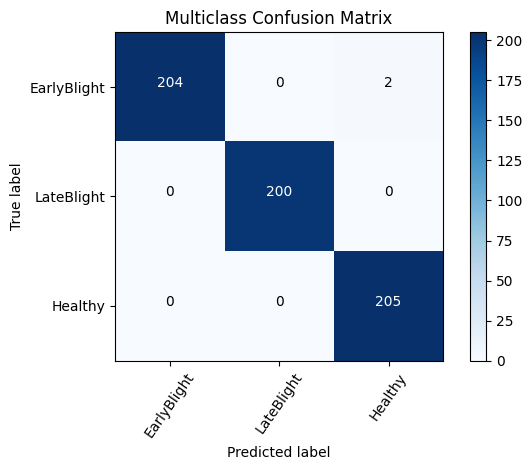

In [15]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlight', 'LateBlight','Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

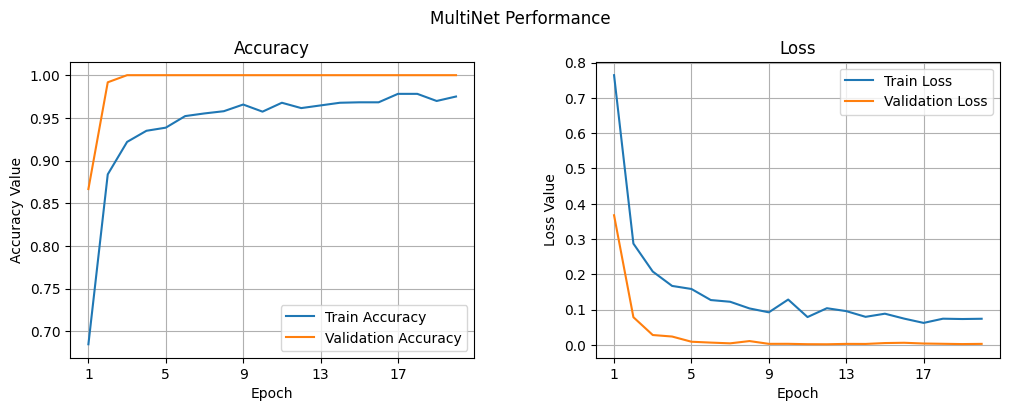

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 21, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 21, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [17]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight', 'LateBlight', 'Healthy']
print(classification_report(y_test, Y_pred, target_names=target_names))

20/20 [==============================] - 3s 135ms/step
Classification Report
              precision    recall  f1-score   support

 EarlyBlight       1.00      0.99      1.00       206
  LateBlight       1.00      1.00      1.00       200
     Healthy       0.99      1.00      1.00       205

    accuracy                           1.00       611
   macro avg       1.00      1.00      1.00       611
weighted avg       1.00      1.00      1.00       611



In [18]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred,1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("Xception")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

20/20 [==============================] - 3s 134ms/step
Xception
Accuracy: 0.9967266775777414
F1 Score: 0.9967267163336309
precision: 0.9967584574070837
recall: 0.9967266775777414
MSE: 0.01309328968903437
MAE: 0.006546644844517185


In [19]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

20/20 [==============================] - 3s 134ms/step


In [59]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=2)
auc=metrics.auc(fpr, tpr)
auc

0.9975369458128079

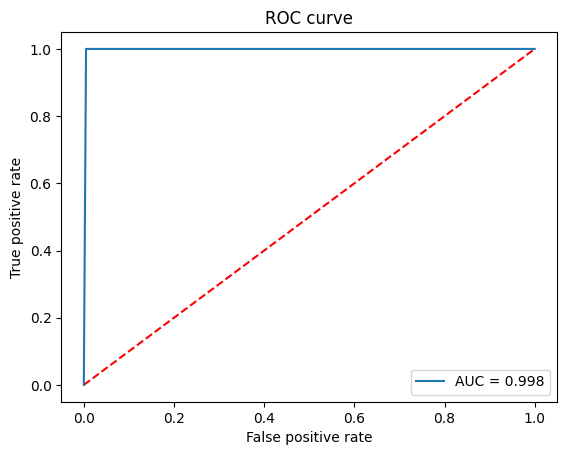

In [60]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()


i- 0
y_test- 0
Y_pred- 0
i- 1
y_test- 0
Y_pred- 0
i- 2
y_test- 0
Y_pred- 0
i- 3
y_test- 0
Y_pred- 0
i- 4
y_test- 0
Y_pred- 0
i- 5
y_test- 0
Y_pred- 0
i- 6
y_test- 0
Y_pred- 0
i- 7
y_test- 0
Y_pred- 0


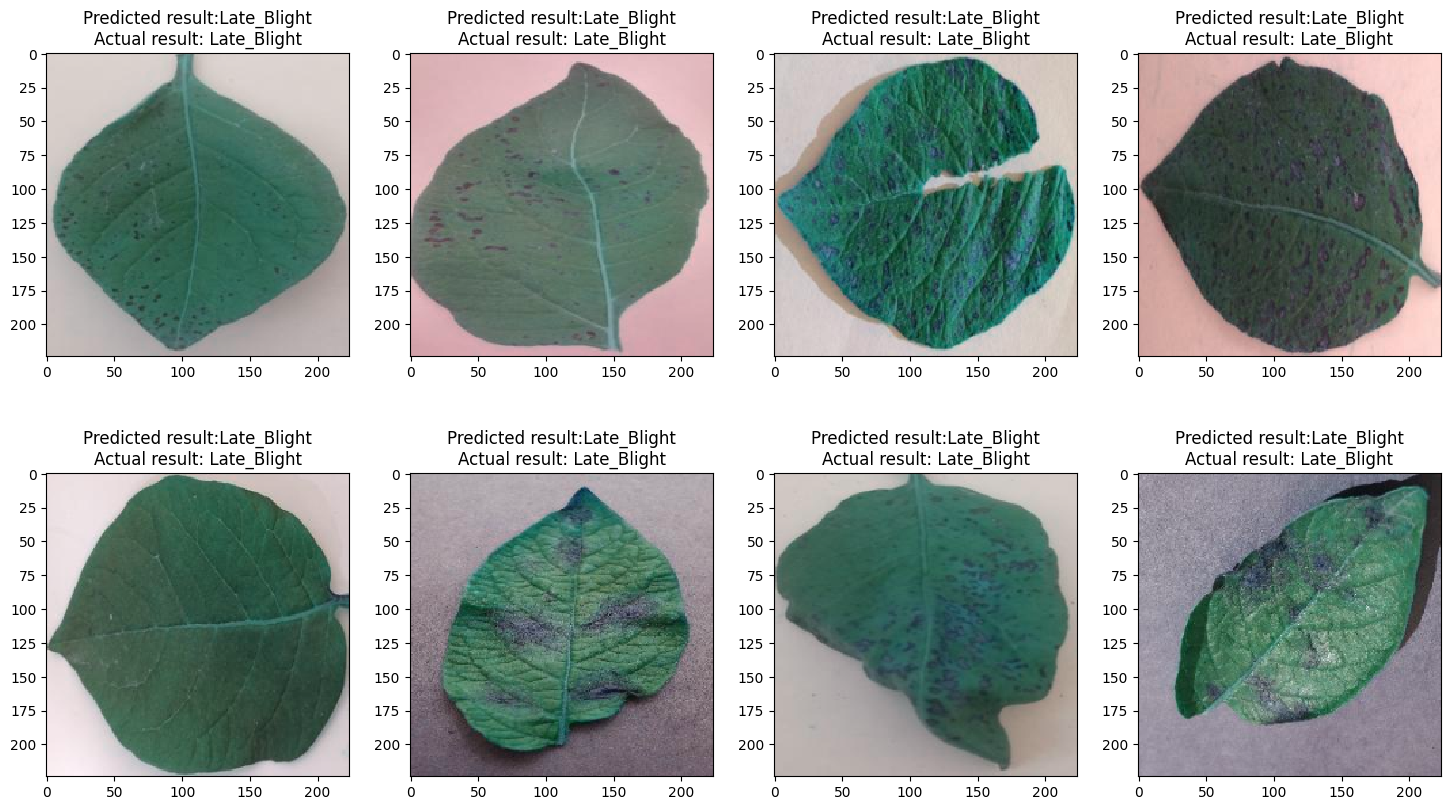

In [48]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
  if(np.argmax(y_test[i])==np.argmax(Y_pred[i])):
    prop_class.append(i)
    print("i-",i)
    print("y_test-",np.argmax(y_test[i]))
    print("Y_pred-",np.argmax(Y_pred[i]))
  if(len(prop_class)==8):
       break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of Early_Blight
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==2:
        return "Early_Blight"
    if namecode==0:
        return "Late_Blight"
    if namecode==1:
        return "Healthy"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()
